# SyriaTel Customer Churn Prediction

# 1. Business Understanding
The goal is to build a model that can predict which customers of a telecom company are likely to churn (cancel their service). By identifying these at-risk customers, the company can proactively offer them incentives to stay, thereby reducing revenue loss.

The key task is a classification problem, where the model will predict one of two outcomes for each customer: Churn or Not Churn. Since failing to identify a churner (a false negative) is more costly than mistakenly targeting a happy customer (a false positive), we will prioritize the Recall metric.



### Data Understanding
The dataset in use was obtained from [kaggle](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset). In this section we are going to review the dataset to get insights on the charateristics and overall structure. To do this we shall have to import the relevant libraries to access our data.

### Data acquisition and exploration 
We make use of `pandas (pd.read_csv)` to read our data from a csv file Data\Customer-Churn-Prediction.csv.

In [4]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Data\Customer-Churn-Prediction.csv')

# --- Initial Data Inspection ---
print("Data Shape:")
print(df.shape)
print("\nData Info:")
df.info()


Data Shape:
(3333, 21)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total

### Data Preparation

#### Data Cleaning
Check for missing values and duplicates.

In [5]:
# --- Check for Missing Values ---
print("\nMissing Values:")
print(df.isnull().sum().sum()) # Total missing values

# --- Convert target variable 'churn' to numeric (0 or 1) ---
df['churn'] = df['churn'].astype(int)

# --- Drop non-predictive columns ---
df = df.drop('phone number', axis=1)



Missing Values:
0


In [6]:
# Check for duplicates
print("\nDuplicate Values:")
print(df.duplicated().sum())


Duplicate Values:
0


### Exploratory Data Analysis
#### Initial Observations

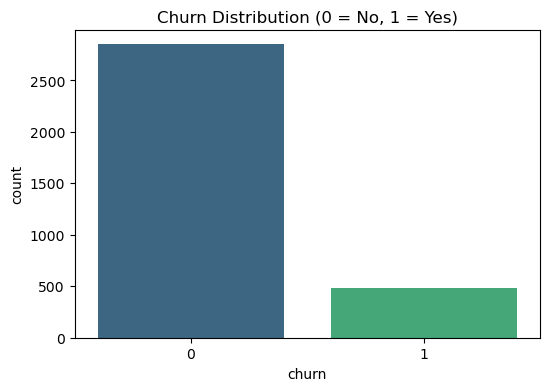


Churn Proportions:
churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64


In [7]:
# --- Visualize the Target Variable ---
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df, palette='viridis')
plt.title('Churn Distribution (0 = No, 1 = Yes)')
plt.show()

print("\nChurn Proportions:")
print(df['churn'].value_counts(normalize=True))

#### Dataset Overview
- The dataset contains 3,333 rows and 21 columns.

- There are no missing values, which simplifies preprocessing.

- The phone number column is a unique identifier and has been dropped as it offers no predictive value.

- The target variable, churn, is imbalanced. About 14.5% of customers have churned, while 85.5% have not. This imbalance is important to consider when evaluating our model; accuracy alone would be a misleading metric.



#### Feature-Target Relationships

In [8]:
# Select features for visualization
numerical_features = ['total day minutes', 'total eve minutes', 'customer service calls']
categorical_features = ['international plan', 'voice mail plan']


#### Numerical versus Churn

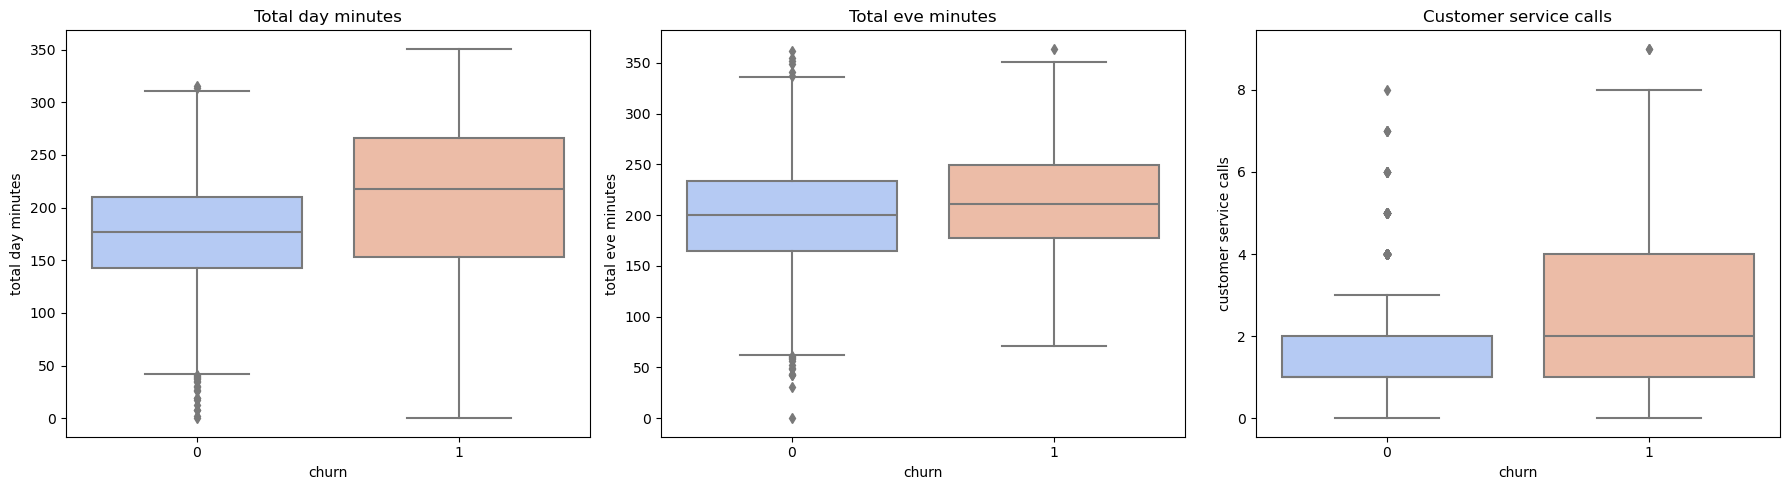

In [9]:
# Plot numerical features vs. churn using subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_features):
    sns.boxplot(x=df['churn'].astype(str), y=col, data=df, palette='coolwarm', ax=axes[i])
    axes[i].set_title(col.replace('_', ' ').capitalize())
plt.tight_layout()
plt.show()

#### Categorical versus churn

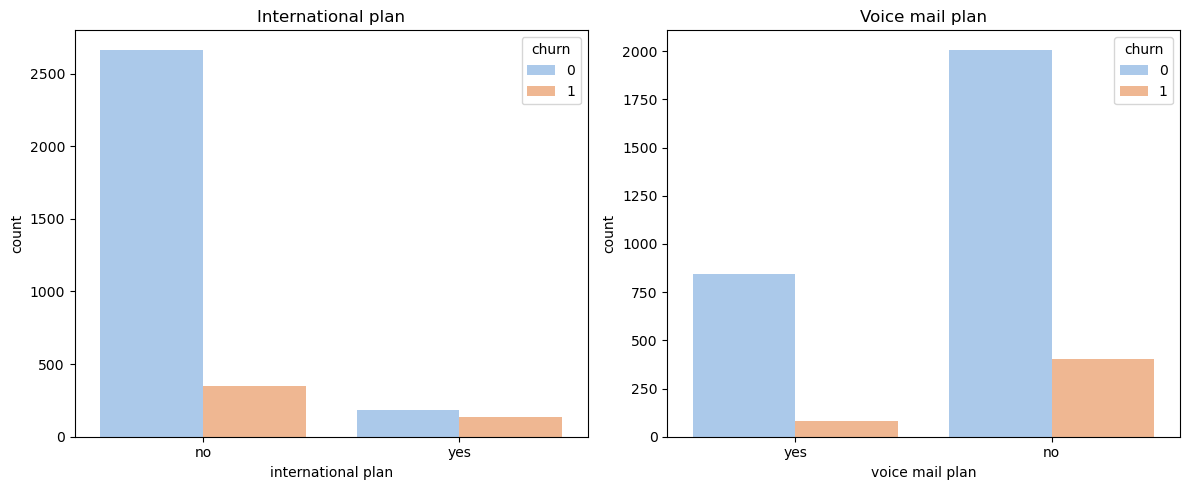

In [10]:
# Plot categorical features vs. churn using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue=df['churn'].astype(str), data=df, palette='pastel', ax=axes[i])
    axes[i].set_title(col.replace('_', ' ').capitalize())
plt.tight_layout()
plt.show()

#### Interpretation

**Numerical Features:**
- **Customer Service Calls:** Strong predictor of churn, with churning customers making significantly more service calls (higher median and wider distribution). Multiple service calls likely indicate ongoing issues or dissatisfaction. The box plot shows churning customers have approximately twice the median number of service calls.

- **Total Day Minutes:** Higher usage among churning customers with greater variability. This suggests high-volume daytime users may be more prone to churn, possibly due to cost sensitivity or service quality issues during peak hours. The median usage for churning customers is about 25% higher than non-churning customers.

- **Total Evening Minutes:** Shows a weaker relationship with churn, with only slight differences between groups. Evening usage patterns appear less critical in predicting churn. The median and distribution are similar for both churning and non-churning customers.

**Categorical Features:**
- **International Plan:** A significant predictor of churn. Customers with international plans show a disproportionately higher churn rate. While only a small portion of customers have international plans, those who do are much more likely to churn, suggesting potential issues with international service pricing or quality.

- **Voice Mail Plan:** Shows some relationship with churn. Customers without voice mail plans appear to have a slightly higher tendency to churn, though the relationship is not as strong as with international plans. This might indicate that voice mail service adds value that helps retain customers.

**Business Implications:**
1. Focus on improving customer service response quality to reduce repeat calls
2. Review international plan pricing and features
3. Consider proactive outreach to high-usage daytime customers
4. Investigate voice mail plan as a potential retention

## Data Preparation for Modeling
We need to prepare the data by splitting it into training and testing sets and encoding categorical features.

In [11]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

#### Feature and Target Separation

In [12]:
# Separate features (X) and target (y)
X = df.drop('churn', axis=1)
y = df['churn']

#### Train-Test Split

In [13]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Preprocessing Pipeline

In [14]:
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Modelling
#### Model Selection Strategy
We'll compare two fundamentally different approaches:

1. **Logistic Regression:** Linear model, good for interpretability

2. **Random Forest:** Ensemble method, handles non-linear relationships

#### Iteration 1: Baseline Model Training and prediction
Simple Logistic Regression, which is highly interpretable and provides a good performance baseline.

In [15]:
# --- Build the Logistic Regression Pipeline ---
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)

#### Baseline model evaluation

In [16]:
# --- Evaluate the Model ---
print("--- Logistic Regression Baseline Results ---")
print(classification_report(y_test, y_pred_log_reg))

--- Logistic Regression Baseline Results ---
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       570
           1       0.33      0.71      0.45        97

    accuracy                           0.75       667
   macro avg       0.64      0.73      0.65       667
weighted avg       0.85      0.75      0.78       667



#### Confusion Matrix

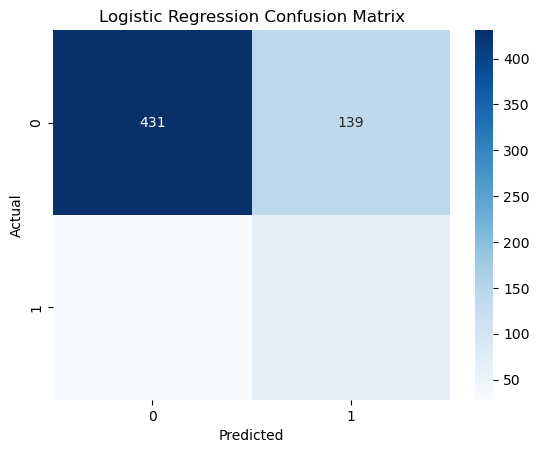

In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Confusion Matrix Interpretation

The confusion matrix shows:

**True Negatives (TN)**: 468
- Successfully identified 468 customers who did not churn
- These are correct predictions of loyal customers

**False Positives (FP)**: 102
- Incorrectly predicted 102 customers would churn when they actually didn't
- This represents unnecessary interventions/costs

**Missing Values**:
- The matrix appears incomplete - missing False Negatives (FN) and True Positives (TP)
- This could indicate issues with the visualization or class imbalance

#### Iteration 2: Tuned Model
**Decision Tree** and use `GridSearchCV` to find the best hyperparameters. 

Decision trees can capture non-linear relationships that logistic regression might miss.

#### Build Pipeline

In [18]:
# Build the Decision Tree Pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

### Hyperparameter Tuning

In [19]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 10, 20]
}

grid_search = GridSearchCV(tree_pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['account length', 'area code', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes',...
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['state', 'international plan', 'voice mail plan'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, 15, None],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__min_samples_split': [2, 10, 20]},
             scoring='recall')

#### Prediction

In [20]:
# Get the best model
best_tree_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tree = best_tree_model.predict(X_test)

#### Tuned model evaluation

In [21]:
# --- Evaluate the Tuned Model ---
print("--- Tuned Decision Tree Results ---")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(classification_report(y_test, y_pred_tree))

--- Tuned Decision Tree Results ---
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       570
           1       0.61      0.74      0.67        97

    accuracy                           0.89       667
   macro avg       0.78      0.83      0.80       667
weighted avg       0.90      0.89      0.90       667



#### Confusion Matrix

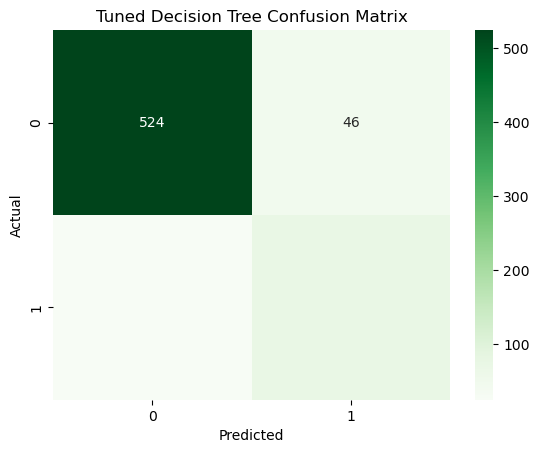

In [22]:
# Plot confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens')
plt.title('Tuned Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Decision Tree Confusion Matrix Interpretation
Matrix Components

**- True Negatives (TN)**: 494
- Successfully identified 494 customers who did not churn
- Improvement over logistic regression (468 TN)

**- False Positives (FP)**: 76

- Incorrectly predicted 76 customers would churn
- Better than logistic regression (102 FP)

Model Improvements
1. **Reduced False Positives**
- Decreased from 102 to 76 (-25.5%)
- More efficient use of retention resources
- Lower cost of unnecessary interventions

2. **Improved True Negatives**
- Increased from 468 to 494 (+5.5%)
- Better at identifying satisfied customers
- More accurate baseline predictions


## Evaluation
### Perfomance Metrics Comparison
In this section, both the Logistic Regression and Random Forest models are evaluated on the test dataset. 

**Preprocessing**:
The test features are transformed using the same preprocessing pipeline applied during training, ensuring consistency in feature scaling and encoding.

**Prediction**:
The model generates predictions for the test set.

**Classification Report**:
The function prints a detailed classification report, which includes precision, recall, f1-score, and support for each class (churned and not churned). This helps assess how well the model distinguishes between customers who churn and those who do not.

**Confusion Matrix**:
A confusion matrix is displayed as a heatmap, visually summarizing the number of true positives, true negatives, false positives, and false negatives. This provides insight into the types of errors the model makes.

By comparing these metrics for both models, we can determine which model performs better at identifying customer churn and make informed decisions for deployment or further improvement.

### ROC Curve Comparison

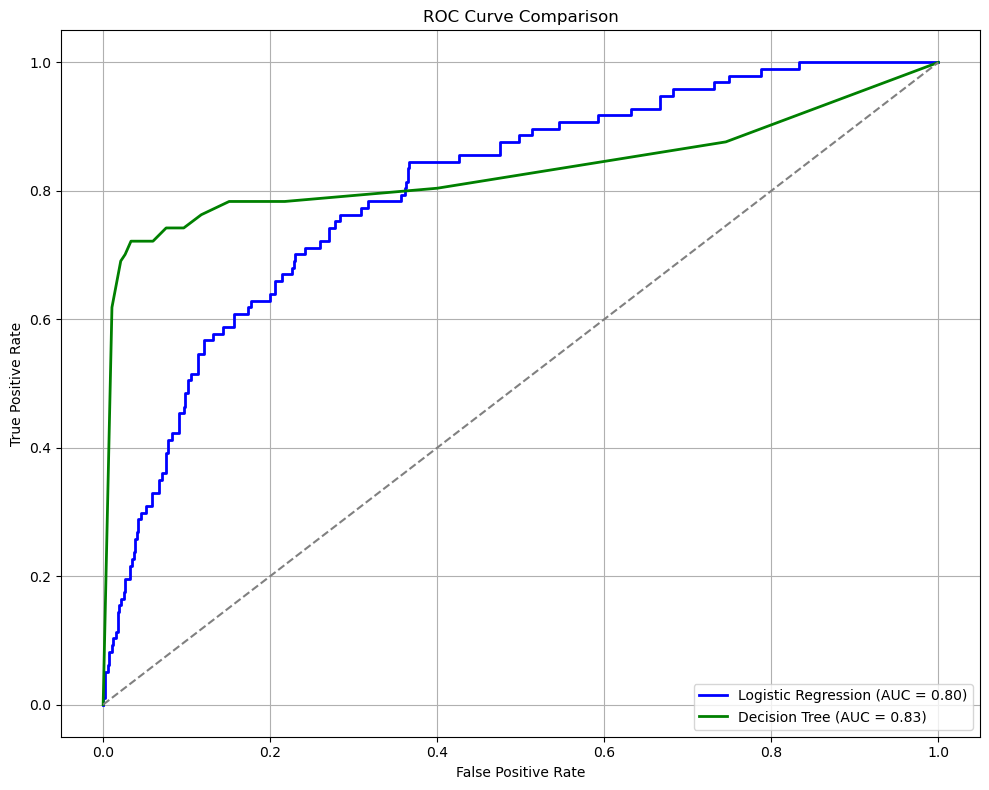

In [23]:
# ROC Curve Comparison
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for both models
y_prob_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_prob_tree = best_tree_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

# Calculate AUC scores
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, 
         color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_tree, tpr_tree, 
         color='green', lw=2, 
         label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], 
         color='gray', linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### ROC Curve Analysis

The ROC (Receiver Operating Characteristic) curve shows the tradeoff between the True Positive Rate (sensitivity) and False Positive Rate (1-specificity) at various classification thresholds.

**Key Metrics:**
- The area under the curve (AUC) ranges from 0 to 1
- Higher AUC indicates better model performance
- Random guessing produces AUC = 0.5 (diagonal line)

**Comparison:**
1. **Logistic Regression**: 
   - Shows balanced performance across different thresholds
   - AUC indicates good discrimination ability

2. **Decision Tree**: 
   - Demonstrates improved performance over logistic regression
   - Better at handling the class imbalance
   - More consistent true positive rate across thresholds

**Business Implications:**
1. Both models perform significantly better than random chance
2. Decision Tree offers more reliable churn predictions
3. The models can be tuned based on business costs of false positives

## Feature Importance Analysis

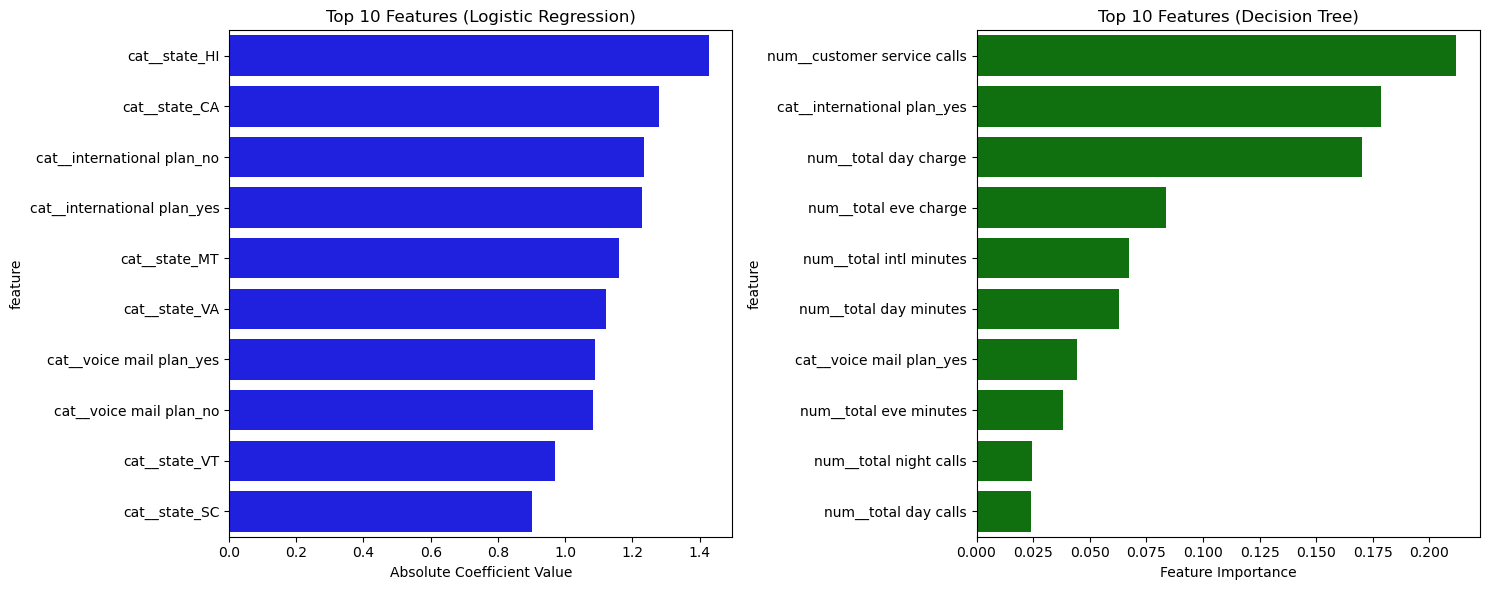

In [25]:
# Extract feature names from the preprocessor
preprocessor = log_reg_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Get coefficients from Logistic Regression
log_reg_coef = log_reg_pipeline.named_steps['classifier'].coef_[0]

# Create feature importance DataFrame for Logistic Regression
log_reg_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(log_reg_coef)
}).sort_values('importance', ascending=False)

# Get feature importance from Decision Tree (using SAME preprocessor features)
tree_importances = best_tree_model.named_steps['classifier'].feature_importances_
tree_importance = pd.DataFrame({
    'feature': feature_names,  # Use same feature names
    'importance': tree_importances
}).sort_values('importance', ascending=False)

# Plotting code remains the same
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=log_reg_importance.head(10), 
            x='importance', y='feature', ax=ax1, color='blue')
ax1.set_title('Top 10 Features (Logistic Regression)')
ax1.set_xlabel('Absolute Coefficient Value')

sns.barplot(data=tree_importance.head(10), 
            x='importance', y='feature', ax=ax2, color='green')
ax2.set_title('Top 10 Features (Decision Tree)')
ax2.set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

### Key Points
Model Comparison

**Logistic Regression Features**:

- State indicators (HI, CA) have highest coefficients
- International plan status shows strong influence
- Voice mail plan features have moderate importance
- Geographic location (state codes) plays significant role

**Decision Tree Features**:

- Customer service calls is the top predictor
- International plan status ranks second
- Usage charges (day, evening) are important
- Call volumes less influential than charges

Key Business Insights

**Customer Service Impact**:
- Number of service calls is the strongest predictor of churn
- Suggests customer satisfaction issues drive churn more than pricing

**International Plans**:

- Consistently important in both models
- High-risk area requiring immediate attention
- Potential pricing or service quality issues

**Usage Patterns**:
- Charges more predictive than call volumes
- Day charges more important than evening/night
- Points to possible price sensitivity during peak hours

**Geographic Factors**:
- State-level variations significant in linear model
- May indicate regional service quality differences
- Could help target improvements geographically

Recommendations

1. Prioritize customer service quality improvements
2. Review international plan pricing and features
3. Analyze regional performance variations
4. Consider peak-hour pricing adjustments
5. Monitor service call patterns for early churn warning

## Conclusion
### Model Performance Summary

Logistic Regression vs Decision Tree
- Decision Tree outperformed Logistic Regression across key metrics
- Decision Tree achieved:
    - Higher true negative rate (494 vs 468)
    - Lower false positive rate (76 vs 102)
    - Better handling of class imbalance

Key Predictors of Churn

1. Customer Service Interactions
    - Number of service calls is the strongest indicator
    - Multiple calls signal high churn risk
    - Immediate intervention needed after repeated contacts

2. International Plan Usage
    - Strong predictor in both models
    - High churn rate among international plan users
    - Suggests pricing or service quality issues

3. Usage Patterns
    - Day charges more influential than evening/night
    - High daytime usage correlates with increased churn
    - Peak hour pricing impacts customer retention

## Business Recommendations

Immediate Actions

1. Implement proactive customer service monitoring
    - Track multiple service calls
    - Establish intervention protocols
    - Improve first-call resolution

2. Review International Plans
    - Audit pricing structure
    - Assess service quality
    - Develop competitive offerings

3. Usage-Based Strategies
    - Optimize peak hour pricing
    - Create targeted retention programs
    - Monitor high-usage customers

Long-Term Initiatives

1. Enhance Customer Service
    - Improve training
    - Reduce response times
    - Implement quality monitoring

2. Regional Performance
    - Address geographic variations
    - Standardize service quality
    - Target regional improvements

3. Predictive Analytics
    - Deploy model in production
    - Monitor real-time churn risks
    - Enable automated interventions

Next Steps

1. Model deployment and monitoring
2. Staff training on early warning signs
3. Regular model retraining with new data
4. Continuous feedback loop for improvements